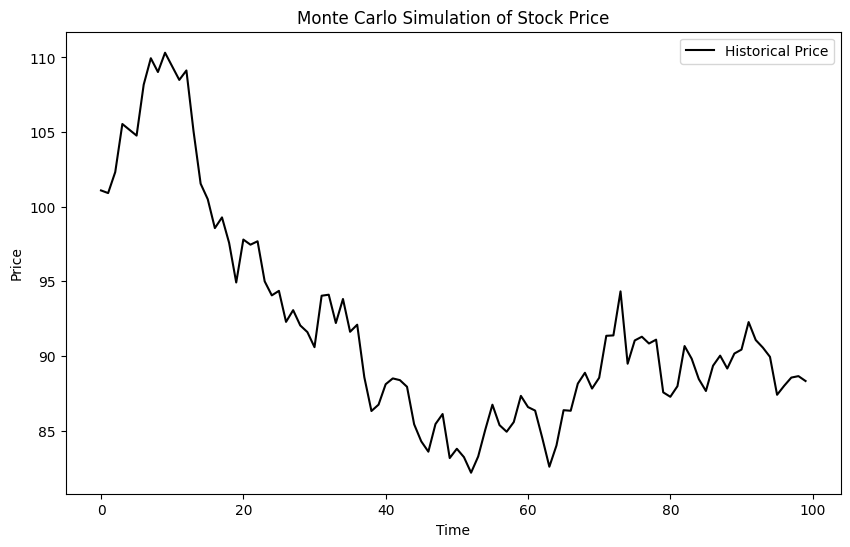

In [16]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import matplotlib.pyplot as plt

# Generate synthetic stock price data
np.random.seed(42)
days = 100
true_drift = 0.001  # Daily drift
true_volatility = 0.02  # Daily volatility

returns = np.random.normal(true_drift, true_volatility, days)
price = 100 * (1 + returns).cumprod()
time = np.arange(days)

plt.figure(figsize=(10, 6))
plt.plot(time, price, label='Historical Price', color='black')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Monte Carlo Simulation of Stock Price')
plt.legend()
plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drift, volatility]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.


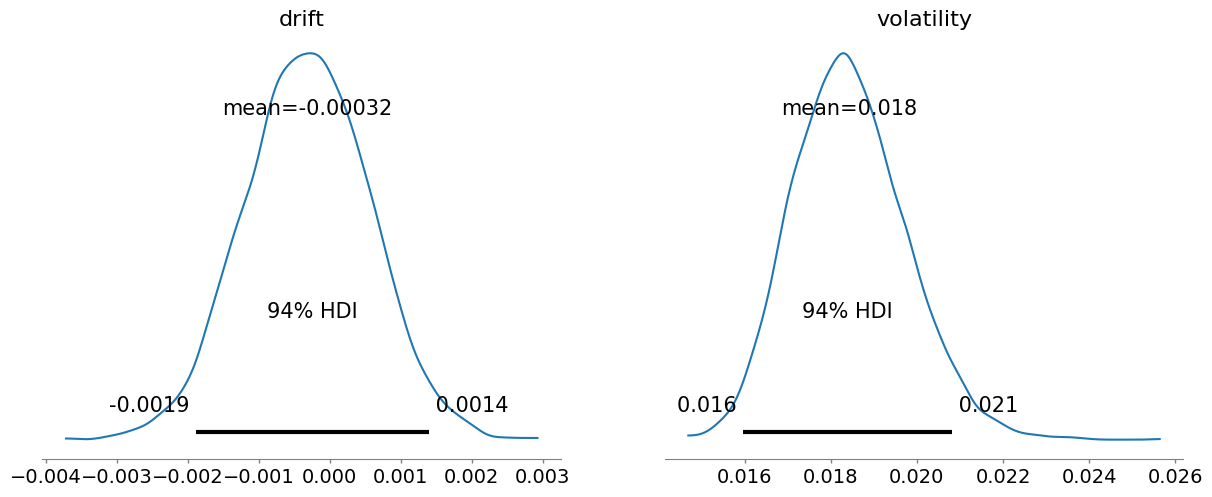

In [17]:
# Build the Bayesian Model
with pm.Model() as model:
    # Priors for drift and volatility
    drift = pm.Normal('drift', mu=0, sigma=0.001)
    volatility = pm.HalfNormal('volatility', sigma=0.05)
    
    # Likelihood (Observed Data)
    returns_obs = pm.Normal('returns_obs', mu=drift, sigma=volatility, observed=np.diff(np.log(price)))
    
    # Inference using MCMC
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

# Posterior Summary
az.plot_posterior(trace, var_names=['drift', 'volatility'])
plt.show()


Sampling: [returns_obs]


Output()

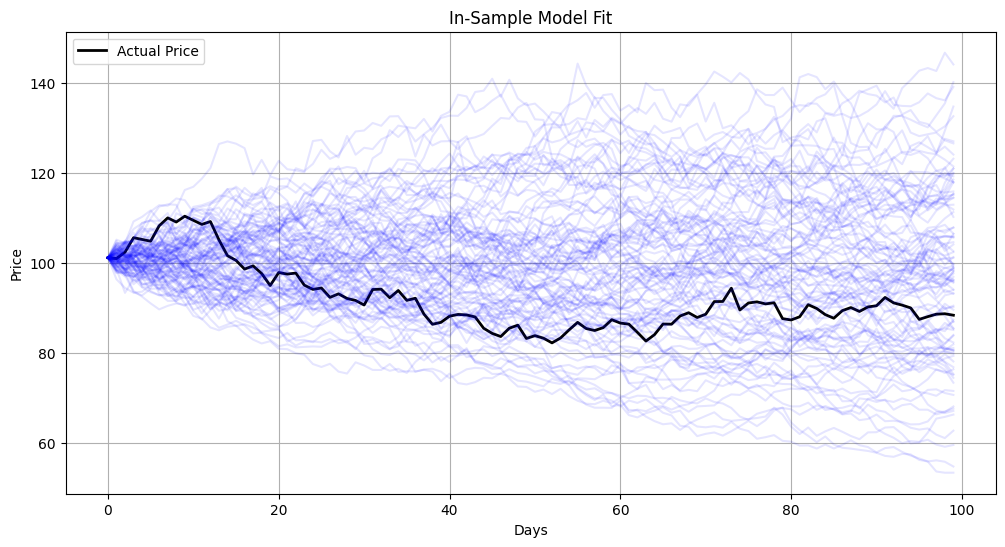

In [3]:
# In-sample predictions
with model:
    in_sample_posterior = pm.sample_posterior_predictive(trace, var_names=['returns_obs'])
posterior = in_sample_posterior.posterior_predictive['returns_obs']
# Convert returns to prices
in_sample_paths = []
for chain in posterior:
    for path in chain[:100]:
        price_path = [price[0]]  # Start with first actual price
        for ret in path:
            price_path.append(price_path[-1] * np.exp(ret))
        in_sample_paths.append(price_path)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(time, price, label='Actual Price', color='black', linewidth=2)
for path in in_sample_paths[:100]:  # Plot first 100 paths for clarity
    plt.plot(time, path, color='blue', alpha=0.1)
plt.title("In-Sample Model Fit")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
with model:
    in_sample_posterior = pm.sample_posterior_predictive(trace, var_names=['returns_obs'])
posterior = in_sample_posterior.posterior_predictive['returns_obs']
# Convert returns to prices
in_sample_paths = []
for chain in posterior:
    for path in chain:
        price_path = [price[0]]  # Start with first actual price
        for ret in path:
            price_path.append(price_path[-1] * np.exp(ret))
        in_sample_paths.append(price_path)



Sampling: [returns_obs]


Output()

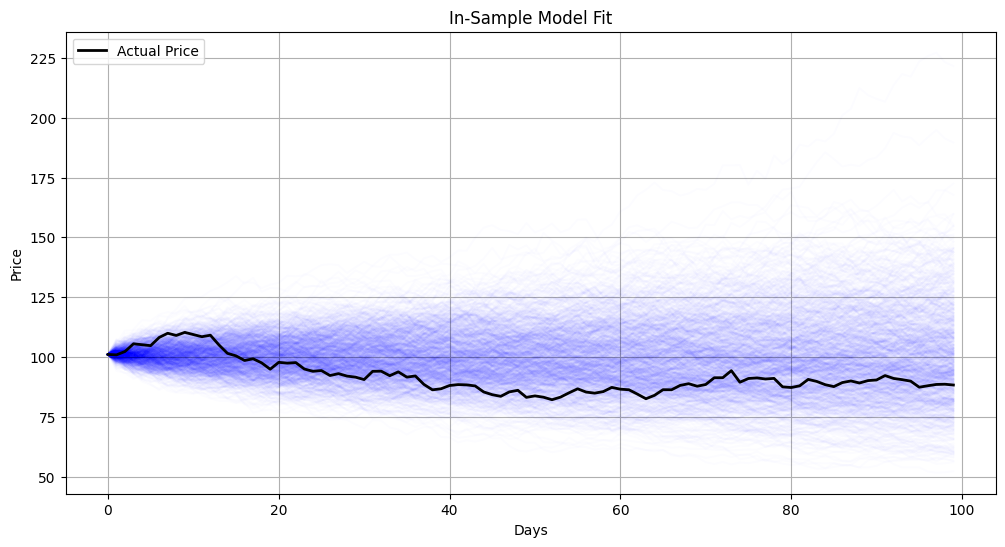

In [9]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
for path in in_sample_paths[1:1000]:  # Plot first 100 paths for clarity
    plt.plot(time, path, color='blue', alpha=0.01)
plt.plot(time, price, label='Actual Price', color='black', linewidth=2)
plt.title("In-Sample Model Fit")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Forecast Simulation
# Suppress ipywidgets warning
import warnings
warnings.filterwarnings('ignore', message='install "ipywidgets" for Jupyter support')

simulations = 100
forecast_steps = 50
forecast_paths = []

with model:
    for _ in range(simulations):
        posterior_samples = pm.sample_posterior_predictive(trace, var_names=['drift', 'volatility'], random_seed=np.random.randint(10000))
        drift_sample = posterior_samples.posterior_predictive['drift'].mean()
        volatility_sample = posterior_samples.posterior_predictive['volatility'].mean()
        path = [price[-1]]
        for _ in range(forecast_steps):
            shock = np.random.normal(drift_sample, volatility_sample)
            path.append(path[-1] * (1 + shock))
        forecast_paths.append(path)

# Plotting the Simulations
plt.figure(figsize=(12, 6))
plt.plot(time, price, label='Historical Price', color='black')
for path in forecast_paths:
    plt.plot(np.arange(days, days + forecast_steps + 1), path, color='blue', alpha=0.1)
plt.title("Bayesian Monte Carlo Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


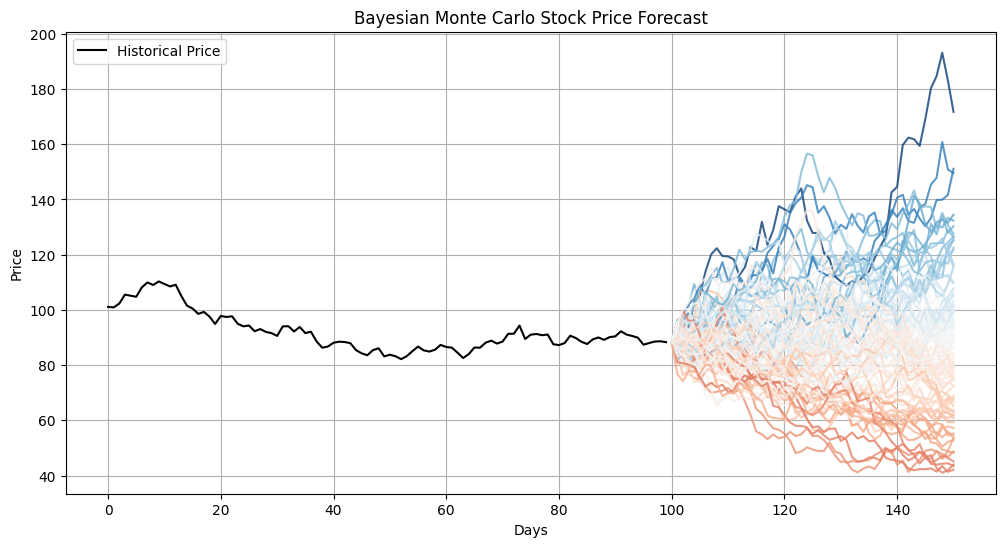

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(time, price, label='Historical Price', color='black')
for path in forecast_paths:
    pct_change = (path[-1] - path[0]) / path[0]
    color = plt.cm.RdBu(0.5 * (pct_change + 1))
    plt.plot(np.arange(days, days + forecast_steps + 1), path, color=color, alpha=0.8)
plt.title("Bayesian Monte Carlo Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Model parameters
days = 100
time = np.arange(days)

# True parameter values
true_rho = np.random.normal(0.4, 0.005)  # AR coefficient
true_drift = np.random.normal(1, 0.5)     # Drift term
true_sigma = 20                           # Noise standard deviation

# Generate price series
prices = np.zeros(days)
prices[0] = 100  # Initial price

# Generate the AR(1) process with drift
for t in range(1, days):
    # price_t = rho * price_{t-1} + drift*t + noise
    noise = np.random.normal(0, true_sigma)
    prices[t] = true_rho * prices[t-1] + true_drift * t + noise

# Plot the generated prices
plt.figure(figsize=(12, 6))
plt.plot(time, prices, label='Simulated Price')
plt.title(f'Simulated AR(1) Process with Drift\n(rho={true_rho:.3f}, drift={true_drift:.3f}, sigma={true_sigma})')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print(f"True parameters:")
print(f"rho: {true_rho:.4f}")
print(f"drift: {true_drift:.4f}")
print(f"sigma: {true_sigma}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


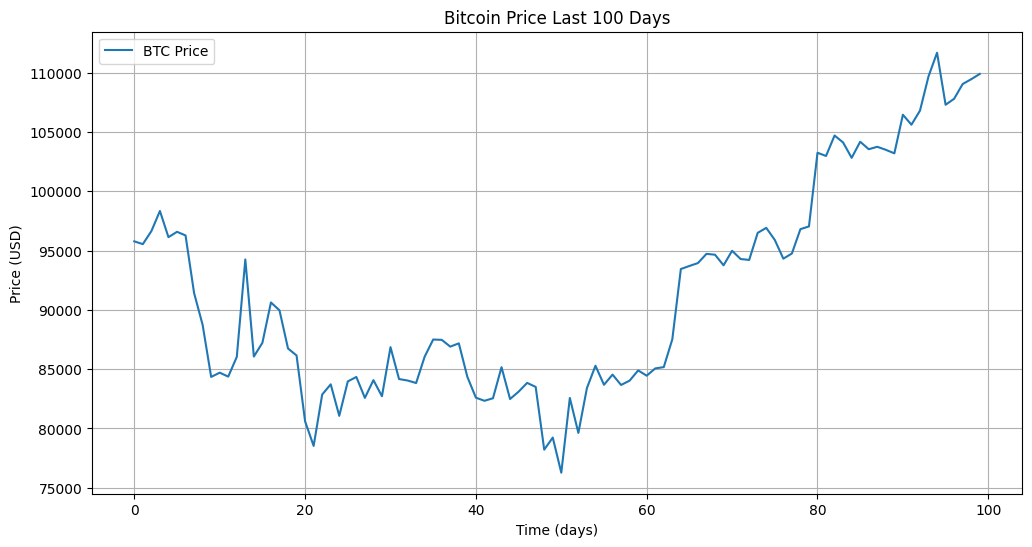

In [12]:
import yfinance as yf
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Get BTC-USD data for last 100 days
btc = yf.download('BTC-USD', period='100d')

# Extract closing prices and convert to numpy array
prices = btc['Close'].values

# Create time array
days = len(prices)
time = np.arange(days)

# Plot the BTC prices
plt.figure(figsize=(12, 6))
plt.plot(time, prices, label='BTC Price')
plt.title('Bitcoin Price Last 100 Days')
plt.xlabel('Time (days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [151]:
prices = prices[:,0]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, drift, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


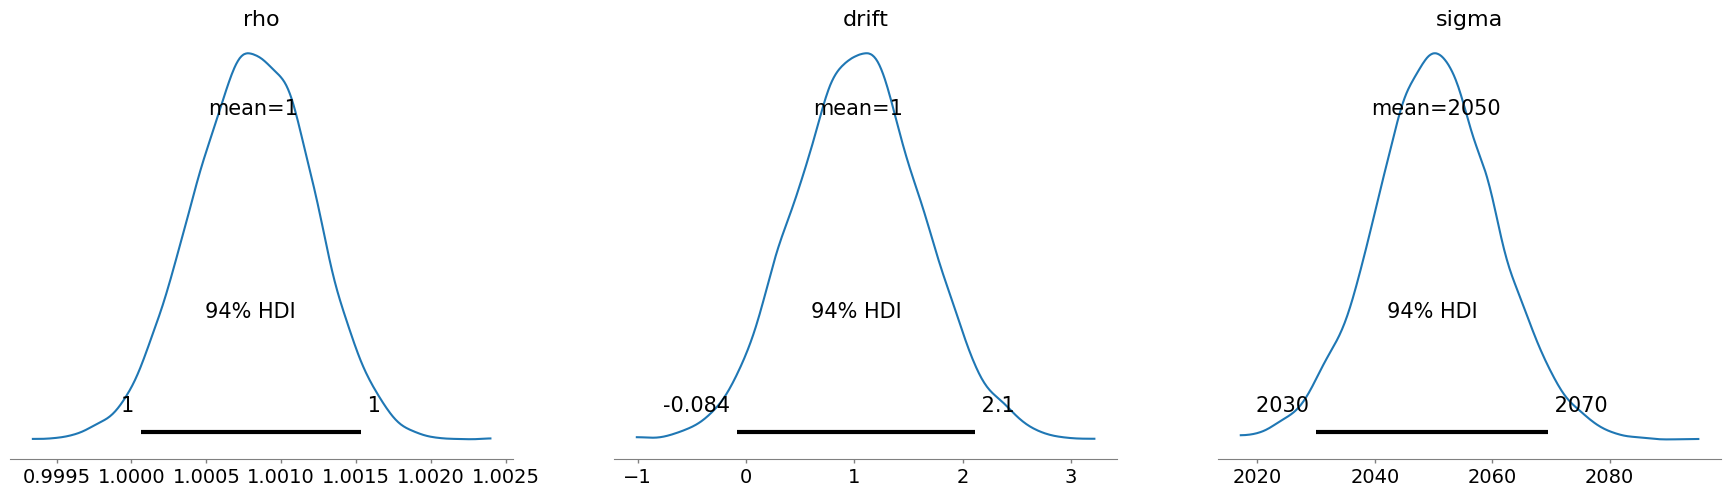


Parameter Estimates:
           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
rho       1.001   0.000     1.000     1.002      0.000    0.000    4343.0   
drift     1.035   0.590    -0.084     2.116      0.009    0.007    4366.0   
sigma  2050.399  10.438  2029.908  2069.563      0.151    0.126    4799.0   

       ess_tail  r_hat  
rho      4596.0    1.0  
drift    4692.0    1.0  
sigma    4506.0    1.0  

True vs Estimated Values:


NameError: name 'true_rho' is not defined

In [13]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Use the synthetic data from previous cell
observed_prices = prices  # This uses the prices array we generated

with pm.Model() as model:
    # Priors
    rho = pm.Normal('rho', mu=0.4, sigma=0.1)  # Made prior slightly wider for exploration
    drift = pm.Normal('drift', mu=1, sigma=1.0)
    sigma = pm.HalfNormal('sigma', sigma=30)
    
    # Calculate expected values
    # We'll use the observed prices[t-1] to predict prices[t]
    expected_values = rho * observed_prices[:-1] + drift * np.arange(1, len(observed_prices))
    
    # Likelihood
    observed = pm.Normal('observed', 
                        mu=expected_values,
                        sigma=sigma, 
                        observed=observed_prices[1:])
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Plot the posterior distributions
az.plot_posterior(trace, var_names=['rho', 'drift', 'sigma'])
plt.show()

# Print summary statistics
summary = az.summary(trace, var_names=['rho', 'drift', 'sigma'])
print("\nParameter Estimates:")
print(summary)

# Compare with true values
print("\nTrue vs Estimated Values:")
print(f"rho:    true = {true_rho:.4f}, estimated = {summary.loc['rho', 'mean']:.4f}")
print(f"drift:  true = {true_drift:.4f}, estimated = {summary.loc['drift', 'mean']:.4f}")
print(f"sigma:  true = {true_sigma:.4f}, estimated = {summary.loc['sigma', 'mean']:.4f}")

In [14]:
# Generate fitted values and prediction intervals
with model:
    posterior_pred = pm.sample_posterior_predictive(trace)

# Extract the predicted values
predicted_values = posterior_pred.posterior_predictive['observed'].mean(axis=(0,1))

# Calculate 95% credible intervals
pred_intervals = np.percentile(
    posterior_pred.posterior_predictive['observed'], 
    q=[2.5, 97.5], 
    axis=(0,1)
)

# Plotting
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(time[1:], observed_prices[1:], 'k.', label='Observed Data', alpha=0.5)

# Plot the model fit
plt.plot(time[1:], predicted_values, 'r-', label='Model Fit', linewidth=2)

# Plot the credible intervals
plt.fill_between(time[1:], pred_intervals[0], pred_intervals[1], 
                color='r', alpha=0.2, label='95% Credible Interval')

plt.title('AR(1) Model Fit with Drift')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print R-squared
ss_tot = np.sum((observed_prices[1:] - np.mean(observed_prices[1:]))**2)
ss_res = np.sum((observed_prices[1:] - predicted_values)**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"\nR-squared: {r_squared:.4f}")

Sampling: [observed]


Output()

ValueError: Output size (99, 1) is not compatible with broadcast dimensions of inputs (99, 99).
Apply node that caused the error: normal_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x345194BA0>), [99  1], Add.0, ExpandDims{axes=[0, 1]}.0)
Toposort index: 6
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(float64, shape=(99, 99)), TensorType(float64, shape=(1, 1))]
Inputs shapes: ['No shapes', (2,), (99, 99), (1, 1)]
Inputs strides: ['No strides', (8,), (792, 8), (8, 8)]
Inputs values: [Generator(PCG64) at 0x345194BA0, array([99,  1]), 'not shown', array([[2066.84686142]])]
Outputs clients: [[output[2](normal_rv{"(),()->()"}.0)], [output[1](observed), DeepCopyOp(observed)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/sheharyar/miniconda3/envs/pymc_test/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/sheharyar/miniconda3/envs/pymc_test/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3365, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/sheharyar/miniconda3/envs/pymc_test/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3610, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/sheharyar/miniconda3/envs/pymc_test/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3670, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_71001/4180833484.py", line 20, in <module>
    observed = pm.Normal('observed',
  File "/Users/sheharyar/miniconda3/envs/pymc_test/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 505, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/Users/sheharyar/miniconda3/envs/pymc_test/lib/python3.12/site-packages/pymc/distributions/continuous.py", line 495, in dist
    return super().dist([mu, sigma], **kwargs)
  File "/Users/sheharyar/miniconda3/envs/pymc_test/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 574, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_71001/3347258127.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[t] = next_price


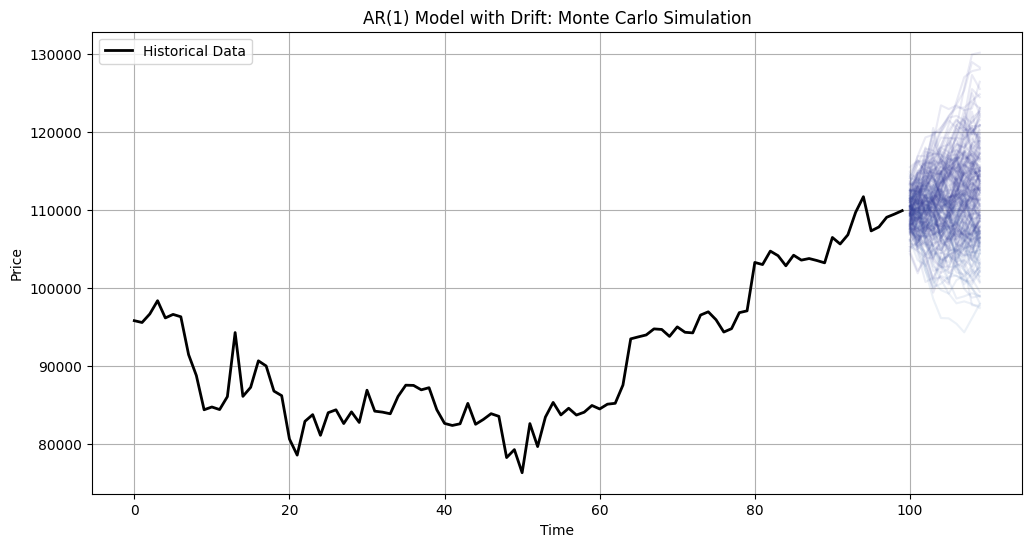


Final Day (t+10) Statistics:
Mean: 111766.27
Median: 111860.92
90% Interval: [101804.52, 122034.39]


In [15]:
# Forecast parameters
n_forecast = 10
n_simulations = 1000

# Create array to store forecasts
forecasts = np.zeros((n_simulations, n_forecast))

# Get posterior samples
posterior_rho = trace.posterior['rho'].values.flatten()
posterior_drift = trace.posterior['drift'].values.flatten()
posterior_sigma = trace.posterior['sigma'].values.flatten()

# Generate forecasts
for i in range(n_simulations):
    # Randomly select parameters from posterior
    idx = np.random.randint(len(posterior_rho))
    rho = posterior_rho[idx]
    drift = posterior_drift[idx]
    sigma = posterior_sigma[idx]
    
    # Initialize forecast with last observed price
    forecast = np.zeros(n_forecast)
    last_price = observed_prices[-1]
    
    # Generate forecast
    for t in range(n_forecast):
        noise = np.random.normal(0, sigma)
        next_price = rho * last_price + drift * (len(observed_prices) + t) + noise
        forecast[t] = next_price
        last_price = next_price
    
    forecasts[i] = forecast

# Plotting with multiple paths
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(time, observed_prices, 'k-', linewidth=2, label='Historical Data')

# Plot Monte Carlo paths
forecast_time = np.arange(len(observed_prices), len(observed_prices) + n_forecast)
for path in forecasts[:200]:  # Plot first 200 paths for clarity
    # Color paths based on final value compared to start
    pct_change = (path[-1] - path[0]) / path[0]
    color = plt.cm.RdYlBu( (pct_change + 1))  # Red for down, Blue for up
    plt.plot(forecast_time, path, color=color, alpha=0.1)

plt.title('AR(1) Model with Drift: Monte Carlo Simulation')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics for final day
final_day_prices = forecasts[:, -1]
print("\nFinal Day (t+10) Statistics:")
print(f"Mean: {np.mean(final_day_prices):.2f}")
print(f"Median: {np.median(final_day_prices):.2f}")
print(f"90% Interval: [{np.percentile(final_day_prices, 5):.2f}, {np.percentile(final_day_prices, 95):.2f}]")